<a href="https://colab.research.google.com/github/asuzukosi/modular-transformer/blob/main/src/learning/TransformersForMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rough notes based on the transformers for machine learning book
We will be experimenting with ideas based on the transformers for machine learnining book and be extracting components for the construction of the modular transformer project

#### Initial project setup
Install the dependencies and setup the project

In [1]:
# install required packages
!pip install torch torchtext spacy

In [2]:
# use spacy to get the french language corpus
!python -m spacy download fr

2023-10-23 00:02:18.175391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 00:02:19.901503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-23 00:02:22.551264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-23 00:02:22.551736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [3]:
# import required packages

# for handing utility functions
from io import open
import unicodedata
import string
import re
import random
import os

# for building neural matrix functions
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# for fetching and processing the dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator
from collections import Counter

# for data visualization and analysis
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker


In [4]:
# download and unzip the training data
%%capture
!wget https://download.pytorch.org/tutorial/data.zip && unzip data.zip && rm data.zip

In [5]:
# set the constants used in building the model
MAX_SENTENCE_LENGTH = 20
FILTER_TO_BASIC_PREFIXES = False
SAVE_DIR = os.path.join(".", "models")

ENCODER_EMBEDDING_DIM = 256
ENCODER_HIDDEN_SIZE = 256
DECODER_EMBEDDING_DIM = 256
DECODER_HIDDEN_SIZE = 256

In [6]:
# set the device type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
if torch.cuda.is_available():
    !nvidia-smi

Mon Oct 23 00:02:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Tring to import and explore data by my self
I'm trying to perfrom the tasks done in data exploration and visualization by retreiving from memory

In [8]:
data = []
with open("/content/data/eng-fra.txt", "r+",  encoding="utf-8") as f:
  lines = f.read().strip().split("\n")

In [9]:
lines[0]

'Go.\tVa !'

In [10]:
# we need to setup the tokenizers
fr_tokenizer = get_tokenizer("spacy", language="fr")
en_tokenizer = get_tokenizer("spacy", language="en")


KeyboardInterrupt: ignored

#### Exporing and visualizing the data
In this section we would export and view the data in our donwloaded datasdet

In [11]:
# open the data translation file and view 5 samples
with open('data/eng-fra.txt', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')

print(f"{len(lines):,} English-French phrase pairs.\n")
print("~~~~~ Examples: ~~~~~")
for example in random.choices(lines, k=5):
    pair = example.split('\t')
    print(f"English:  {pair[0]}")
    print(f"French:   {pair[1]}")
    print()

135,842 English-French phrase pairs.

~~~~~ Examples: ~~~~~
English:  I could hardly endure the pain.
French:   Je pouvais à peine endurer la douleur.

English:  I'm tired of waiting in line.
French:   Je suis fatigué de faire la file.

English:  That would be really funny.
French:   Ce serait vraiment drôle.

English:  It's surprising that you haven't heard anything about her wedding.
French:   Il est surprenant que tu n'aies rien entendu au sujet de ses noces.

English:  We can't do this without some help.
French:   Nous n'arrivons pas à le faire sans aide.



In [12]:
def unicodeToAscii(s):
    return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z.!?]+", " ", s)
    return s

In [13]:
def filterPair(p, max_length, prefixes):
    good_length = (len(p[0].split(' ')) < max_length) and (len(p[1].split(' ')) < max_length)
    if len(prefixes) == 0:
        return good_length
    else:
        return good_length and p[0].startswith(prefixes)

def filterPairs(pairs, max_length, prefixes=()):
    return [pair for pair in pairs if filterPair(pair, max_length, prefixes)]


In [14]:
def prepareData(lines, filter=False, reverse=False, max_length=10, prefixes=()):
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    print(f"Given {len(pairs):,} sentence pairs.")

    if filter:
        pairs = filterPairs(pairs, max_length=max_length, prefixes=prefixes)
        print(f"After filtering, {len(pairs):,} remain.")

    return pairs

In [15]:
basic_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ",
    'are you', 'am i ',
    'were you', 'was i ',
    'where are', 'where is',
    'what is', 'what are'
)

In [16]:
pairs = prepareData(lines,
                    filter=True,
                    max_length=MAX_SENTENCE_LENGTH,
                    prefixes=basic_prefixes if FILTER_TO_BASIC_PREFIXES else ())


Given 135,842 sentence pairs.
After filtering, 135,284 remain.


In [17]:
print(pairs[:4])

[['go.', 'va !'], ['run!', 'cours !'], ['run!', 'courez !'], ['wow!', 'ca alors !']]


In [18]:
# setup tokenizers for tokenizing languages

fr_tokenizer = get_tokenizer('spacy', language='fr')
en_tokenizer = get_tokenizer('spacy', language='en')

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "fr" could not be loaded, trying "fr_core_news_sm" instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [19]:
# SPECIALS = ['', '', '', '']
SPECIALS = ['<bos>', '<eos>', '<pad>']

In [20]:
en_list = []
fr_list = []
en_counter = Counter()
fr_counter = Counter()
en_lengths = []
fr_lengths = []
for en, fr in pairs:
    en_toks = en_tokenizer(en)
    fr_toks = fr_tokenizer(fr)
    en_list += [en_toks]
    fr_list += [fr_toks]
    en_counter.update(en_toks)
    fr_counter.update(fr_toks)
    en_lengths.append(len(en_toks))
    fr_lengths.append(len(fr_toks))

In [21]:
fr_list[200]

['appelle', 'tom', '.']

In [22]:
# build both english and french vocabularies
en_vocab = build_vocab_from_iterator(en_list, specials=SPECIALS)
fr_vocab = build_vocab_from_iterator(fr_list, specials=SPECIALS)

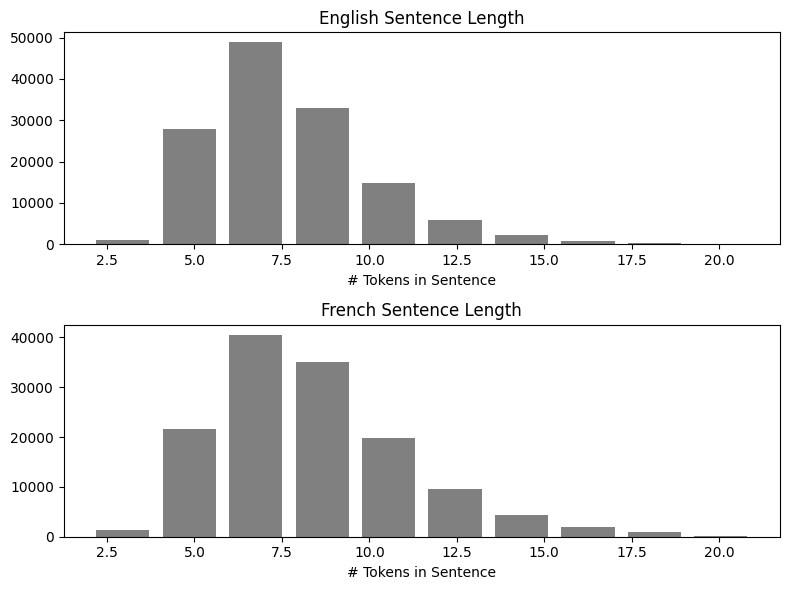

In [23]:
# plot a chart to show the number of tokens in sentence and frequence of sentences with that number of tokens for both languages
fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_subplot(211)
ax0.hist(en_lengths, rwidth=0.8, color='gray')
ax0.set_title("English Sentence Length")
ax0.set_xlabel("# Tokens in Sentence")

ax1 = fig.add_subplot(212)
ax1.hist(fr_lengths, rwidth=0.8, color='gray')
ax1.set_title("French Sentence Length")
ax1.set_xlabel("# Tokens in Sentence")

plt.tight_layout()
plt.show()

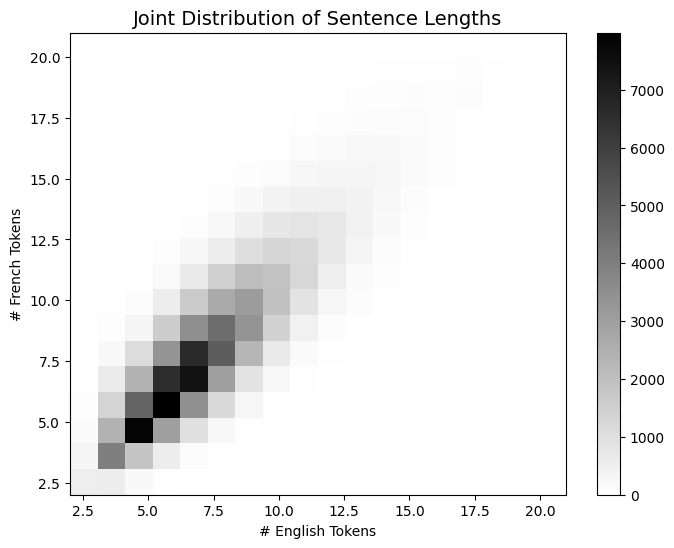

In [24]:

plt.figure(figsize=(8,6))
plt.hist2d(en_lengths, fr_lengths, bins=MAX_SENTENCE_LENGTH-2, cmap='binary')
plt.title("Joint Distribution of Sentence Lengths", fontsize=14)
plt.xlabel("# English Tokens")
plt.ylabel("# French Tokens")
plt.colorbar()
plt.show()


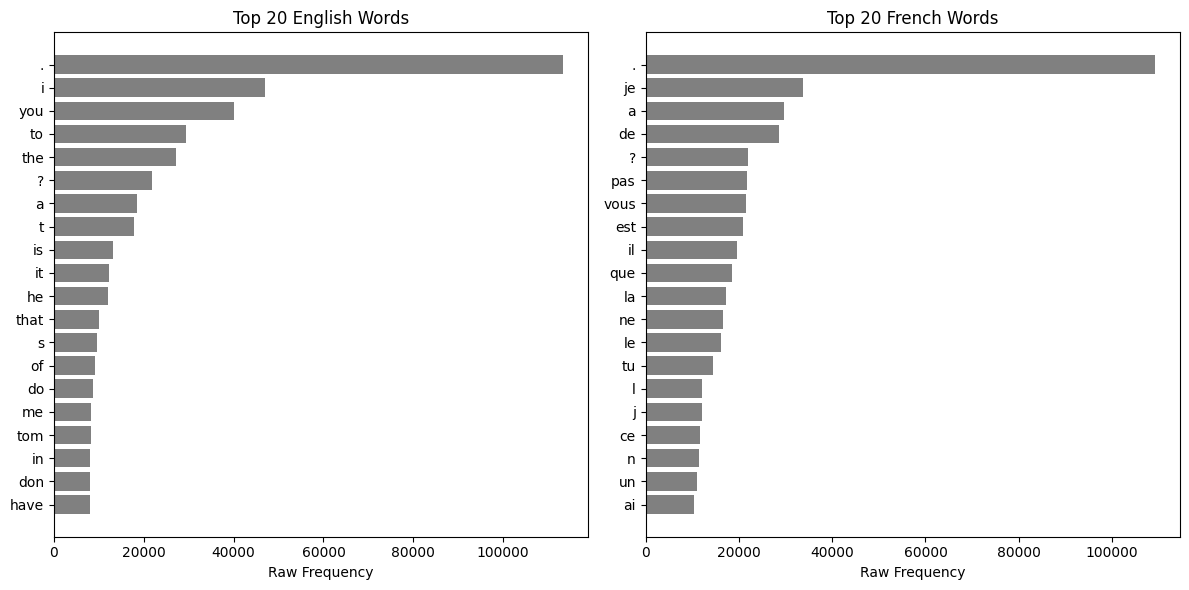

In [25]:
# plot the top k words in both languages

def plot_top_words(counter, k=20, ax=None):
    top_k = counter.most_common(k)
    words, freqs = zip(*reversed(top_k))

    if ax is None:
        plt.barh(words, freqs, color='gray')
    else:
        ax.barh(words, freqs, color='gray')

fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121)
plot_top_words(en_counter, ax=ax0)
ax0.set_title("Top 20 English Words")
ax0.set_xlabel("Raw Frequency")

ax1 = fig.add_subplot(122)
plot_top_words(fr_counter, ax=ax1)
ax1.set_title("Top 20 French Words")
ax1.set_xlabel("Raw Frequency")

plt.tight_layout()
plt.show()


In [26]:
# create training, testing and validation data
VALID_PCT = 0.1
TEST_PCT  = 0.1

train_data = []
valid_data = []
test_data = []

for en, fr in zip(en_list, fr_list):
  en_tensor_ = torch.Tensor([en_vocab[i] for i in en])
  fr_tensor_ = torch.Tensor([fr_vocab[i] for i in fr])

  # split the training data into training, testing and validation in that order of preference
  random_draw = random.random()
  if random_draw <= VALID_PCT:
      valid_data.append((en_tensor_, fr_tensor_))
  elif random_draw <= VALID_PCT + TEST_PCT:
      test_data.append((en_tensor_, fr_tensor_))
  else:
      train_data.append((en_tensor_, fr_tensor_))

In [27]:
train_data[100][1].shape

torch.Size([4])

In [28]:

print(f"""
  Training pairs: {len(train_data):,}
Validation pairs: {len(valid_data):,}
      Test pairs: {len(test_data):,}""")


  Training pairs: 108,178
Validation pairs: 13,654
      Test pairs: 13,452


In [29]:
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

for en_id, fr_id in zip(en_vocab.lookup_indices(SPECIALS), fr_vocab.lookup_indices(SPECIALS)):
  assert en_id == fr_id

In [30]:
def generate_batch(data_batch):
    '''
    Prepare English and French examples for batch-friendly modeling by appending
    BOS/EOS tokens to each, stacking the tensors, and filling trailing spaces of
    shorter sentences with the  token. To be used as the collate_fn in the
    English-to-French DataLoader.

    Input:
    - data_batch, an iterable of (English, French) tuples from the datasets
      created above

    Outputs
    - en_batch: a (max length X batch size) tensor of English token IDs
    - fr_batch: a (max length X batch size) tensor of French token IDs
    '''
    en_batch, fr_batch = [], []
    for (en_item, fr_item) in data_batch:
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
        fr_batch.append(torch.cat([torch.tensor([BOS_IDX]), fr_item, torch.tensor([EOS_IDX])], dim=0))

    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX, batch_first=False)
    fr_batch = pad_sequence(fr_batch, padding_value=PAD_IDX, batch_first=False)

    return en_batch, fr_batch

In [31]:
BATCH_SIZE = 16

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

In [32]:
for i, (en_id, fr_id) in enumerate(train_iter):

    print(en_id[:,0]) # <- the current shape is characters, sentece
    print('English:', ' '.join([en_vocab.lookup_token(idx) for idx in en_id[:, 0]]))
    print('French:', ' '.join([fr_vocab.lookup_token(idx) for idx in fr_id[:, 0]]))
    break
    if i == 4:
        break
    else:
        print()

tensor([  0.,  24.,  43., 537.,   3.,   1.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.])
English: <bos> we all die . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
French: <bos> nous mourons toutes . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


#### Building the models
In this section we would cover builing the models which include the lstm model and the transformer model

In [47]:
class BahdanauEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim,
                 decoder_hidden_dim, dropout_p):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.linear = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        '''
        Encode a source sentence.

        Input:
          - x: a (sequence length, batch size) tensor of token IDs in source language

        Output:
          - outputs: encoder outputs at each time step, given as a tensor of size
            (sequence length, batch size, encoder hidden dim * 2)
          - hidden: final hidden state from RNN, with directions concatenated and
            fed through linear layer; tensor of size (batch size, decoder hidden dim)
        '''
        embedded = self.dropout(self.embedding(x))
        outputs, hidden = self.gru(embedded)

        hidden = torch.tanh(self.linear(
            torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        ))

        return outputs, hidden

In [48]:
class BahdanauAttentionQKV(nn.Module):
    def __init__(self, hidden_size, query_size=None, key_size=None, dropout_p=0.15):
        super().__init__()
        self.hidden_size = hidden_size
        self.query_size = hidden_size if query_size is None else query_size

        # assume bidirectional encoder, but can specify otherwise
        self.key_size = 2*hidden_size if key_size is None else key_size

        self.query_layer = nn.Linear(self.query_size, hidden_size)
        self.key_layer = nn.Linear(self.key_size, hidden_size)
        self.energy_layer = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, hidden, encoder_outputs, src_mask=None):
        '''
        Calculate attention weights using query and key features, with
        an optional mask for input sequences.

        Inputs:
          - hidden: most recent RNN hidden state; (B, Dec)
          - encoder_outputs: RNN outputs at individual time steps with
            directions concatenated; (L, B, 2*Enc)
          - src_mask: boolean tensor of same size as source tokens (Src, B)
            where False denotes tokens to be ignored

        Outputs:
          - attention weights: (B, src) tensor of softmax attention
            weights to be applied to downstream values
        '''

        # (B, H)
        query_out = self.query_layer(hidden)

        # (Src, B, 2*H) --> (Src, B, H)
        key_out = self.key_layer(encoder_outputs)

        # (B, H) + (Src, B, H) = (Src, B, H)
        energy_input = torch.tanh(query_out + key_out)

        # (Src, B, H) --> (Src, B, 1) --> (Src, B)
        energies = self.energy_layer(energy_input).squeeze(2)

        # if a mask is provided, remove masked tokens from softmax calc
        if src_mask is not None:
            energies.data.masked_fill_(src_mask == 0, float("-inf"))

        # softmax over the length dimension
        weights = F.softmax(energies, dim=0)

        # return as (B, Src) as expected by later multiplication
        return weights.transpose(0, 1)


In [49]:
class BahdanauDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, encoder_hidden_dim,
                 decoder_hidden_dim, attention, dropout_p):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.attention = attention # allowing for custom attention
        self.gru = nn.GRU((encoder_hidden_dim * 2) + embedding_dim,
                          decoder_hidden_dim)
        self.out = nn.Linear((encoder_hidden_dim * 2) + embedding_dim + decoder_hidden_dim,
                             output_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input, hidden, encoder_outputs, src_mask=None):
        '''
        Decode an encoder's output.

        B: batch size
        S: source sentence length
        T: target sentence length
        O: output size (target vocab size)
        Enc: encoder hidden dim
        Dec: decoder hidden dim
        Emb: embedding dim

        Inputs:
          - input: a vector of length B giving the most recent decoded token
          - hidden: a (B, Dec) most recent RNN hidden state
          - encoder_outputs: (S, B, 2*Enc) sequence of outputs from encoder RNN

        Outputs:
          - output: logits for next token in the sequence (B, O)
          - hidden: a new (B, Dec) RNN hidden state
          - attentions: (B, S) attention weights for the current token over the source sentence
        '''

        # (B) --> (1, B)
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        attentions = self.attention(hidden, encoder_outputs, src_mask)

        # (B, S) --> (B, 1, S)
        a = attentions.unsqueeze(1)

        # (S, B, 2*Enc) --> (B, S, 2*Enc)
        encoder_outputs = encoder_outputs.transpose(0, 1)

        # weighted encoder representation
        # (B, 1, S) @ (B, S, 2*Enc) = (B, 1, 2*Enc)
        weighted = torch.bmm(a, encoder_outputs)

        # (B, 1, 2*Enc) --> (1, B, 2*Enc)
        weighted = weighted.transpose(0, 1)

        # concat (1, B, Emb) and (1, B, 2*Enc)
        # results in (1, B, Emb + 2*Enc)
        rnn_input = torch.cat((embedded, weighted), dim=2)

        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()

        # get rid of empty leading dimensions
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        # concatenate the pieces above
        # (B, Dec), (B, 2*Enc), and (B, Emb)
        # result is (B, Dec + 2*Enc + Emb)
        linear_input = torch.cat((output, weighted, embedded), dim=1)

        # (B, Dec + 2*Enc + Emb) --> (B, O)
        output = self.out(linear_input)

        return output, hidden.squeeze(0), attentions

In [50]:
class BahdanauSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device
        self.tgt_vocab_size = decoder.output_dim

    def forward(self, src, tgt, src_mask=None, teacher_forcing_ratio=0.5, return_attentions=False):

        tgt_length, batch_size = tgt.shape

        # store decoder outputs
        outputs = torch.zeros(tgt_length, batch_size, self.tgt_vocab_size).to(self.device)
        # attentions = torch.zeros(tgt_length, batch_size, )

        encoder_outputs, hidden = self.encoder(src)
        hidden = hidden.squeeze(1) # B, 1, Enc --> B, Enc (if necessary)

        # start with  as the decoder input
        decoder_input = tgt[0, :]
        attentions = []

        for t in range(1, tgt_length):
            decoder_output, hidden, attention = self.decoder(decoder_input, hidden, encoder_outputs, src_mask)
            outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top_token = decoder_output.max(1)[1]
            decoder_input = (tgt[t] if teacher_force else top_token)
            attentions.append(attention.unsqueeze(-1))

        if return_attentions:
            return outputs, torch.cat(attentions, dim=-1)
        else:
            return outputs

In [51]:
class MultipleOptimizer(object):
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

In [52]:
# for i, (src, tgt) in enumerate(train_iter):
#   src = src.to(torch.long)
#   print(src[:, 0])
#   break

In [53]:
def train(model, iterator, optimizer, loss_fn, device, clip=None):
    model.train()
    if model.device != device:
        model = model.to(device)

    epoch_loss = 0
    with tqdm(total=len(iterator), leave=False) as t:
        for i, (src, tgt) in enumerate(iterator):
            src_mask = (src != PAD_IDX).to(device)
            src = src.to(torch.long).to(device)

            tgt = tgt.to(torch.long).to(device)

            optimizer.zero_grad()

            output = model(src, tgt, src_mask)

            loss = loss_fn(output[1:].view(-1, output.shape[2]),
                           tgt[1:].view(-1))

            loss.backward()

            # if clip is not None:
            #     nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
            epoch_loss += loss.item()

            avg_loss = epoch_loss / (i+1)
            t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                          ppl='{:05.3f}'.format(np.exp(avg_loss)))
            t.update()

    return epoch_loss / len(iterator)

In [54]:
def evaluate(model, iterator, loss_fn, device):
    model.eval()
    if model.device != device:
        model = model.to(device)

    epoch_loss = 0
    with torch.no_grad():
        with tqdm(total=len(iterator), leave=False) as t:
            for i, (src, tgt) in enumerate(iterator):
                src_mask = (src != PAD_IDX).to(device)
                src = src.to(torch.long).to(device)

                tgt = tgt.to(torch.long).to(device)

                output = model(src, tgt, src_mask, teacher_forcing_ratio=0)
                loss = loss_fn(output[1:].view(-1, output.shape[2]),
                               tgt[1:].view(-1))

                epoch_loss += loss.item()

                avg_loss = epoch_loss / (i+1)
                t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                              ppl='{:05.3f}'.format(np.exp(avg_loss)))
                t.update()

    return epoch_loss / len(iterator)

In [55]:
enc = BahdanauEncoder(input_dim=len(en_vocab),
                      embedding_dim=ENCODER_EMBEDDING_DIM,
                      encoder_hidden_dim=ENCODER_HIDDEN_SIZE,
                      decoder_hidden_dim=DECODER_HIDDEN_SIZE,
                      dropout_p=0.15)

attn = BahdanauAttentionQKV(DECODER_HIDDEN_SIZE)

dec = BahdanauDecoder(output_dim=len(fr_vocab),
                      embedding_dim=DECODER_EMBEDDING_DIM,
                      encoder_hidden_dim=ENCODER_HIDDEN_SIZE,
                      decoder_hidden_dim=DECODER_HIDDEN_SIZE,
                      attention=attn,
                      dropout_p=0.15)

In [56]:
seq2seq = BahdanauSeq2Seq(enc, dec, device)


In [57]:
def count_params(model, return_int=False):
    params = sum([torch.prod(torch.tensor(x.shape)).item() for x in model.parameters() if x.requires_grad])
    if return_int:
        return params
    else:
        print("There are {:,} trainable parameters in this model.".format(params))


In [58]:
count_params(seq2seq)

There are 32,359,877 trainable parameters in this model.


In [59]:
enc_optim = torch.optim.AdamW(seq2seq.encoder.parameters(), lr=1e-4)
dec_optim = torch.optim.AdamW(seq2seq.decoder.parameters(), lr=1e-4)
optims = MultipleOptimizer(enc_optim, dec_optim)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [60]:
# # import gdrive
# from google.colab import drive
# drive.mount('/content/gdrive')

# PROJECT_DIR = "/transformers_chapter1/bahdanau_en_fr/"
# MODEL_DIR = os.path.join(PROJECT_DIR, "gru")

# STATS = os.path.join(MODEL_DIR, "config.json")
# MODEL = os.path.join(MODEL_DIR, "bahdanau_en_fr.pt")

In [61]:
# import json

# N_EPOCHS = 20
# CLIP = 10 # clipping value, or None to prevent gradient clipping
# EARLY_STOPPING_EPOCHS = 2

# def load_stats(STATS_PATH):
#   if not os.path.exists(STATS_PATH):
#     os.makedirs(STATS_PATH)
#     data = {
#         "COMPLETED": 0,
#         "N_EPOCHS": N_EPOCHS,
#         "CLIP": CLIP,
#         "EARLY_STOPPING_EPOCHS": EARLY_STOPPING_EPOCHS,
#       }
#     with open(STATS_PATH, "w+") as f:
#       json.dump(data, f)

#     return 0, N_EPOCHS, CLIP, EARLY_STOPPING_EPOCHS
#   else:
#     with open(STATS_PATH, "r+") as f:
#       data = json.loads(f.read())
#       COMPLETED = data["COMPLETED"]
#       N_EPOCHS = data["N_EPOCHS"]
#       CLIP = data["CLIP"]
#       EARLY_STOPPING_EPOCHS = data["EARLY_STOPPING_EPOCHS"]

#       return COMPLETED, N_EPOCHS, CLIP, EARLY_STOPPING_EPOCHS

# def update_completed_stats(STATS_PATH):
#   # JSON file
#   f = open(STATS_PATH, "w+")

#   # Reading from file
#   data = json.loads(f.read())
#   data["COMPLETED"] += 1

#   with open(STATS_PATH, 'r+', encoding='utf-8') as f:
#     json.dump(data, f, ensure_ascii=False, indent=4)


#### Training the RNN attention model
In this section we would be exploring training the model

In [ ]:
N_EPOCHS = 20
CLIP = 10 # clipping value, or None to prevent gradient clipping
EARLY_STOPPING_EPOCHS = 2

if not os.path.exists(SAVE_DIR):
    print(f"Creating directory {SAVE_DIR}")
    os.mkdir(SAVE_DIR)

model_path = os.path.join(SAVE_DIR, 'bahdanau_en_fr.pt')
bahdanau_metrics = {}
best_valid_loss = float("inf")
early_stopping_count = 0
for epoch in tqdm(range(N_EPOCHS), leave=False, desc="Epoch"):
    train_loss = train(seq2seq, train_iter, optims, loss_fn, device, clip=CLIP)
    valid_loss = evaluate(seq2seq, valid_iter, loss_fn, device)

    if valid_loss < best_valid_loss:
        tqdm.write(f"Checkpointing at epoch {epoch + 1}")
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), model_path)
        early_stopping_count = 0
    else:
        early_stopping_count += 1

    bahdanau_metrics[epoch+1] = dict(
        train_loss = train_loss,
        train_ppl = np.exp(train_loss),
        valid_loss = valid_loss,
        valid_ppl = np.exp(valid_loss)
    )

    if early_stopping_count == EARLY_STOPPING_EPOCHS:
        tqdm.write(f"Early stopping triggered in epoch {epoch + 1}")
        break


Creating directory ./models


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 1


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 2


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 3


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 4


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 5


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 6


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 7


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 8


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 9


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 10


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 11


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 12


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Checkpointing at epoch 14


  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/6771 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Early stopping triggered in epoch 16


#### Loading the model
In this section we will be loading a trained model and performing analysis on it

In [96]:
model_path = os.path.join(SAVE_DIR, 'bahdanau_en_fr.pt')

In [99]:
seq2seq.load_state_dict(torch.load(model_path, map_location=device))

RuntimeError: ignored

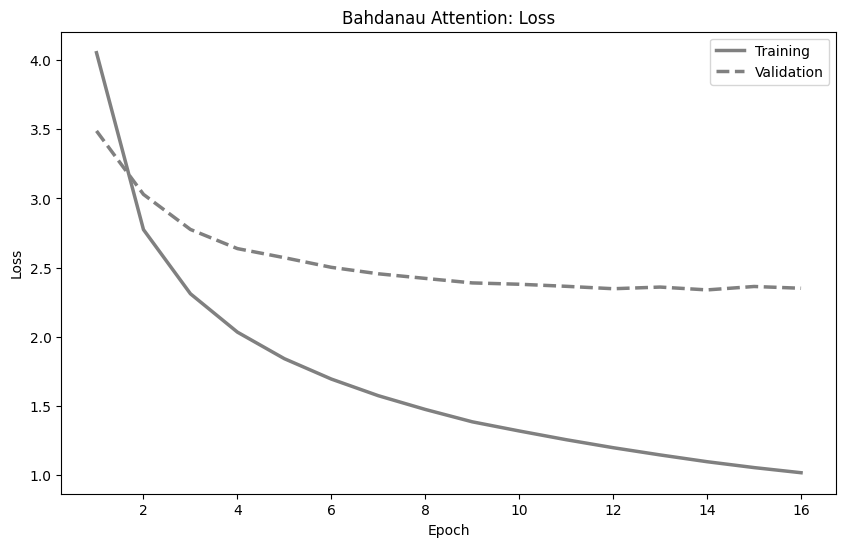

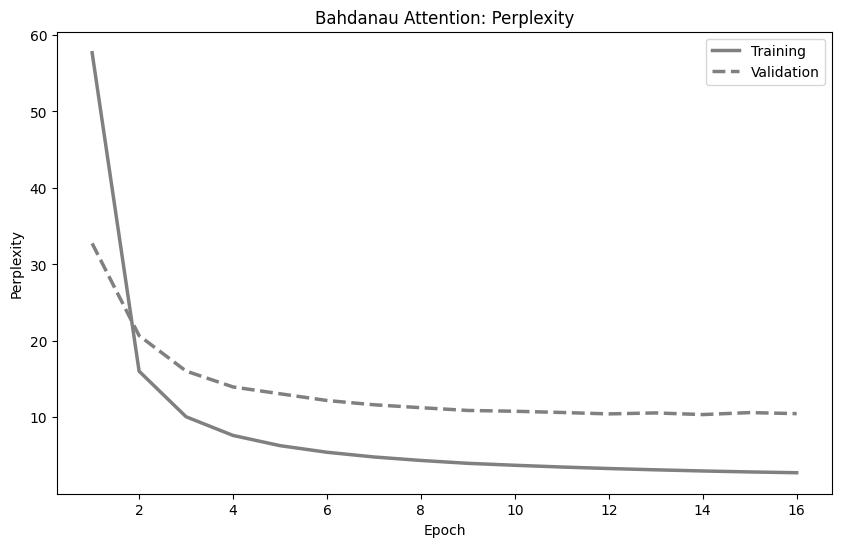

In [ ]:
bahdanau_metrics_df = pd.DataFrame(bahdanau_metrics).T

plt.figure(figsize=(10,6))
plt.plot(bahdanau_metrics_df['train_loss'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(bahdanau_metrics_df['valid_loss'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Bahdanau Attention: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(bahdanau_metrics_df['train_ppl'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(bahdanau_metrics_df['valid_ppl'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Bahdanau Attention: Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.show()

#### Perform text perdictions with GRU rnn model
In this sectionw we will be making predictions with the GRU rnn model and be visualizing the attention for those predictions

In [ ]:
def text_predictions(model, text, src_vocab=en_vocab, src_tokenizer=en_tokenizer, tgt_vocab=fr_vocab)
model.eval()
with torch.no_grad():
  input_ids = [src_vocab[token] for token in src_tokenizer(text)]
  input_ids = [BOS_IDX] + input_ids + [EOS_IDX]
  input_tensor = torch.tensor(input_ids).to(torch.long)to(device).unsqueeze(1) # add fake batch dim
  max_len = 2*len(input_ids)
  encoder_outputs, hidden = model.encoder(input_tensor)

  output = torch.tensor([BOS_IDX]).to(device)

  decoder_outputs = torch.zeros(max_len, 1, len(tgt_vocab)).to(device)

  decoded_words = []
  decoder_attentions = torch.zeros(max_len, len(input_ids))
  for t in range(0, max_len):
    output, hidden, attn = model.decoder(output, hidden, encoder_outputs)
    decoder_attentions[t] = attn.data
    decoder_outputs[t] = output
    output = output.argmax(1)

    if output.item() == EOS_IDX:
      decoded_words.append('')
      break
    else:
      decoded_words.append(tgt_vocab.lookup_token(output.item()))

    output_sentence = ' '.join(decoded_words)
    return output_sentence, decoder_attentions[:(t+1)]


In [ ]:
def show_attention(input_sentence, output_sentence, attentions, figsize=(8,6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='gray')
    fig.colorbar(cax)

    src = ['', ''] + input_sentence.split(' ') + ['']
    tgt = [''] + output_sentence.split(' ')
    ax.set_xticklabels(src, rotation=90)
    ax.set_yticklabels(tgt)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def predict_and_show_attention(sentence, model, device):
    result, attentions = predict_text(model, sentence, device)

    print("Input  >>>", sentence)
    print("Output >>>", result)

    show_attention(sentence, result, attentions)


In [ ]:
predict_and_show_attention("i am going to the store", seq2seq, device)


In [ ]:
predict_and_show_attention("how long will you be here ?", seq2seq, device)

In [ ]:
predict_and_show_attention("can we please go to the library ?", seq2seq, device)

#### Building a transformer model for language translation
We would be repreating the same learning tasks but this time we would be making use of the transformer model

In [86]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout_p=0.1, max_len=100):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout_p)
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)


  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

In [87]:
class TransformerModel(nn.Module):
  def __init__(self, input_dim, output_dim, d_model, num_attention_heads,
               num_encoder_layers, num_decoder_layers, dim_feedforward,
               max_seq_length, pos_dropout, transformer_dropout):
    super().__init__()
    self.embed_src = nn.Embedding(input_dim, d_model)
    self.embed_tgt = nn.Embedding(output_dim, d_model)
    self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

    self.transformer = nn.Transformer(d_model, num_attention_heads, num_encoder_layers,
                                          num_decoder_layers, dim_feedforward, transformer_dropout)
    self.output = nn.Linear(d_model, output_dim)
    self.d_model = d_model

  def forward(self, src=None, tgt=None, src_mask=None, tgt_mask=None, src_key_padding_mask=None,
              tgt_key_padding_mask=None, memory_key_padding_mask=None, src_embeds=None,
              tgt_embeds=None):
    if (src_embeds is None) and (src is not None):
      if (tgt_embeds is None) and (tgt is not None):
        src_embeds, tgt_embeds = self._embed_tokens(src, tgt)
      elif (src_embeds is not None) and (src is not None):
       raise ValueError("Must specify exactly one of src and src_embeds")
      elif (src_embeds is None) and (src is None):
       raise ValueError("Must specify exactly one of src and src_embeds")
      elif (tgt_embeds is not None) and (tgt is not None):
       raise ValueError("Must specify exactly one of tgt and tgt_embeds")
      elif (tgt_embeds is None) and (tgt is None):
        raise ValueError("Must specify exactly one of tgt and tgt_embeds")
    output = self.transformer(src_embeds,
                              tgt_embeds,
                              tgt_mask=tgt_mask,
                              src_key_padding_mask=src_key_padding_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)

    return self.output(output)

  def _embed_tokens(self, src, tgt):
    src_embeds = self.embed_src(src)  * np.sqrt(self.d_model)
    tgt_embeds = self.embed_tgt(tgt)  * np.sqrt(self.d_model)

    # dont forget your positional encoding
    src_embeds = self.pos_enc(src_embeds)
    tgt_embeds = self.pos_enc(tgt_embeds)
    return src_embeds, tgt_embeds


In [88]:
def train_transformer(model, iterator, optimizer, loss_fn, device, clip=None):
    model.train()

    epoch_loss = 0
    with tqdm(total=len(iterator), leave=False) as t:
        for i, (src, tgt) in enumerate(iterator):
            src = src.to(torch.long).to(device)
            tgt = tgt.to(torch.long).to(device)

            # Create tgt_inp and tgt_out (which is tgt_inp but shifted by 1)
            tgt_inp, tgt_out = tgt[:-1, :], tgt[1:, :]

            tgt_mask = model.transformer.generate_square_subsequent_mask(tgt_inp.size(0)).to(device)
            src_key_padding_mask = (src == PAD_IDX).transpose(0, 1)
            tgt_key_padding_mask = (tgt_inp == PAD_IDX).transpose(0, 1)
            memory_key_padding_mask = src_key_padding_mask.clone()

            optimizer.zero_grad()

            output = model(src=src, tgt=tgt_inp,
                           tgt_mask=tgt_mask,
                           src_key_padding_mask = src_key_padding_mask,
                           tgt_key_padding_mask = tgt_key_padding_mask,
                           memory_key_padding_mask = memory_key_padding_mask)

            loss = loss_fn(output.view(-1, output.shape[2]),
                           tgt_out.view(-1))

            loss.backward()

            # if clip is not None:
            #     nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
            epoch_loss += loss.item()

            avg_loss = epoch_loss / (i+1)
            t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                          ppl='{:05.3f}'.format(np.exp(avg_loss)))
            t.update()

    return epoch_loss / len(iterator)

In [89]:
def evaluate_transformer(model, iterator, loss_fn, device):
    model.eval()

    epoch_loss = 0
    with torch.no_grad():
        with tqdm(total=len(iterator), leave=False) as t:
            for i, (src, tgt) in enumerate(iterator):
                src = src.to(torch.long).to(device)
                tgt = tgt.to(torch.long).to(device)

                # Create tgt_inp and tgt_out (which is tgt_inp but shifted by 1)
                tgt_inp, tgt_out = tgt[:-1, :], tgt[1:, :]

                tgt_mask = model.transformer.generate_square_subsequent_mask(tgt_inp.size(0)).to(device)
                src_key_padding_mask = (src == PAD_IDX).transpose(0, 1)
                tgt_key_padding_mask = (tgt_inp == PAD_IDX).transpose(0, 1)
                memory_key_padding_mask = src_key_padding_mask.clone()

                output = model(src=src, tgt=tgt_inp,
                               tgt_mask=tgt_mask,
                               src_key_padding_mask = src_key_padding_mask,
                               tgt_key_padding_mask = tgt_key_padding_mask,
                               memory_key_padding_mask = memory_key_padding_mask)

                loss = loss_fn(output.view(-1, output.shape[2]),
                               tgt_out.view(-1))

                epoch_loss += loss.item()

                avg_loss = epoch_loss / (i+1)
                t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                              ppl='{:05.3f}'.format(np.exp(avg_loss)))
                t.update()

    return epoch_loss / len(iterator)

In [90]:
transformer = TransformerModel(input_dim=len(en_vocab),
                             output_dim=len(fr_vocab),
                             d_model=256,
                             num_attention_heads=8,
                             num_encoder_layers=6,
                             num_decoder_layers=6,
                             dim_feedforward=2048,
                             max_seq_length=32,
                             pos_dropout=0.15,
                             transformer_dropout=0.3)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [91]:
transformer = transformer.to(device)
count_params(transformer)

There are 31,545,284 trainable parameters in this model.


#### Train the transformer language model
In this section we will be training the transformer model

In [92]:
xf_optim = torch.optim.AdamW(transformer.parameters(), lr=1e-4)

In [100]:
%%time
N_EPOCHS = 50
CLIP = 15 # clipping value, or None to prevent gradient clipping
EARLY_STOPPING_EPOCHS = 5

model_path = os.path.join(SAVE_DIR, 'transformer_en_fr.pt')
transformer_metrics = {}
best_valid_loss = float("inf")
early_stopping_count = 0
for epoch in tqdm(range(N_EPOCHS), desc="Epoch"):
    train_loss = train_transformer(transformer, train_iter, xf_optim, loss_fn, device, clip=CLIP)
    valid_loss = evaluate_transformer(transformer, valid_iter, loss_fn, device)

    if valid_loss < best_valid_loss:
        tqdm.write(f"Checkpointing at epoch {epoch + 1}")
        best_valid_loss = valid_loss
        torch.save(transformer.state_dict(), model_path)
        early_stopping_count = 0
    elif epoch > EARLY_STOPPING_EPOCHS:
        early_stopping_count += 1

    transformer_metrics[epoch+1] = dict(
        train_loss = train_loss,
        train_ppl = np.exp(train_loss),
        valid_loss = valid_loss,
        valid_ppl = np.exp(valid_loss)
    )

    if early_stopping_count == EARLY_STOPPING_EPOCHS:
        tqdm.write(f"Early stopping triggered in epoch {epoch + 1}")
        break

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 1


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 2


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 3


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 4


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 5


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 6


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 7


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 8


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 9


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 10


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 11


  0%|          | 0/6762 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Checkpointing at epoch 12


  0%|          | 0/6762 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#### Loading and evaluation of the transformer model
In this section we will load the saved transformer weight checkpoints

In [ ]:
transformer.load_state_dict(torch.load(model_path, map_location=device))

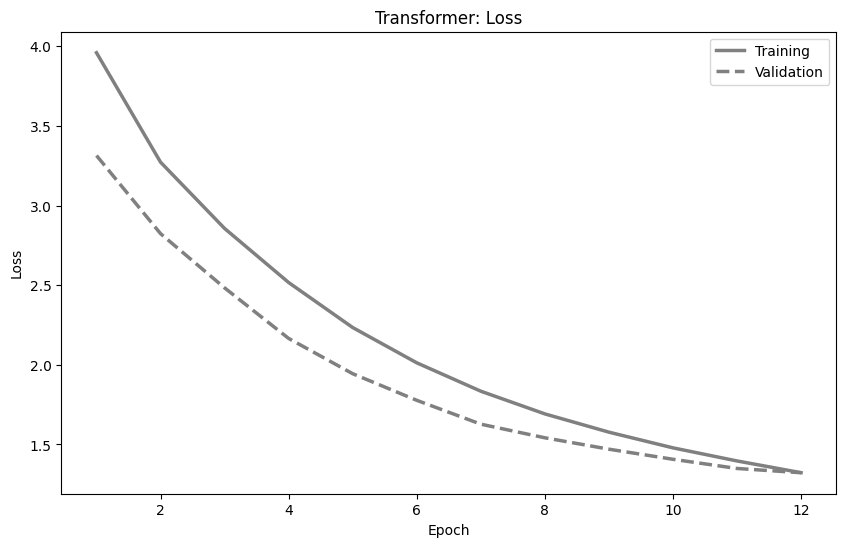

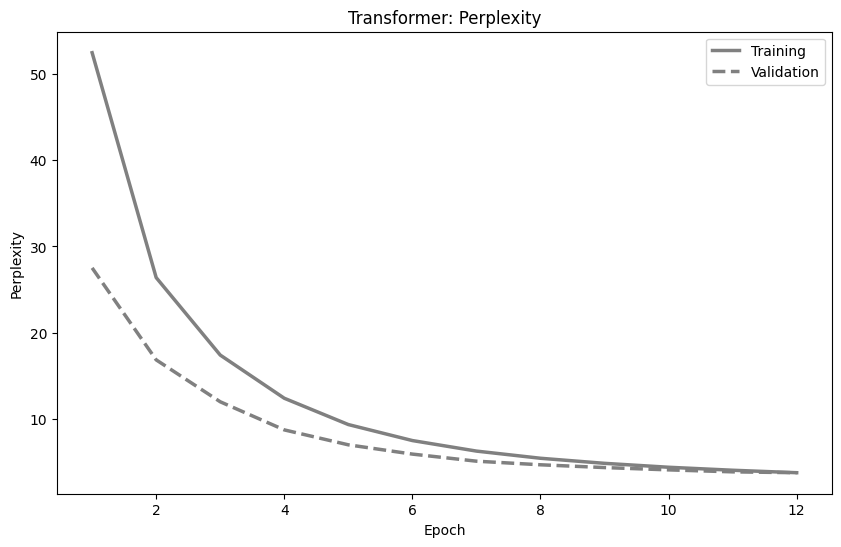

In [101]:
transformer_metrics_df = pd.DataFrame(transformer_metrics).T

plt.figure(figsize=(10,6))
plt.plot(transformer_metrics_df['train_loss'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(transformer_metrics_df['valid_loss'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Transformer: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(transformer_metrics_df['train_ppl'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(transformer_metrics_df['valid_ppl'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Transformer: Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.show()

#### Make predicitons with the trasformer model
We will examine making predictions using the transformer model

In [103]:
def predict_transformer(text, model,
                        src_vocab=en_vocab,
                        src_tokenizer=en_tokenizer,
                        tgt_vocab=fr_vocab,
                        device=device):

    input_ids = [src_vocab[token] for token in src_tokenizer(text)]
    input_ids = [BOS_IDX] + input_ids + [EOS_IDX]

    model.eval()
    with torch.no_grad():
      input_tensor = torch.tensor(input_ids).to(device).unsqueeze(1) # add fake batch dim

      causal_out = torch.ones(MAX_SENTENCE_LENGTH, 1).long().to(device) * BOS_IDX
      for t in range(1, MAX_SENTENCE_LENGTH):
        decoder_output = transformer(input_tensor, causal_out[:t, :])[-1, :, :]
        next_token = decoder_output.data.topk(1)[1].squeeze()
        causal_out[t, :] = next_token
        if next_token.item() == EOS_IDX:
          break

      pred_words = [tgt_vocab.lookup_token(tok.item()) for tok in causal_out.squeeze(1)[1:(t)]]
      return " ".join(pred_words)

In [105]:
predict_transformer("she is not my mother .", transformer)

'elle n est pas ma mere .'

In [111]:
predict_transformer("my name is.", transformer)


'mon nom .'

In [112]:
predict_transformer("i would go anywhere with you .", transformer)


'je t y serais venu .'

In [ ]:
def _one_hot(token_ids, vocab_size, device=device):
    return torch.zeros(token_ids.size(0), vocab_size).to(device).scatter_(1, token_ids, 1.)

def get_embeds(embedding_matrix, position_embedding_layer, input_ids, device=device):
    vocab_size = embedding_matrix.size(0)
    one_hot_tensor = _one_hot(input_ids, vocab_size, device)

    token_ids_tensor_one_hot = one_hot_tensor.to(device).clone().requires_grad_(True)
    inputs_embeds = torch.matmul(token_ids_tensor_one_hot, embedding_matrix)
    inputs_embeds = position_embedding_layer(inputs_embeds.unsqueeze(1))
    return inputs_embeds, token_ids_tensor_one_hot

def predict_and_visualize_transformer(input_text, model=transformer,
                                      src_tokenizer=en_tokenizer,
                                      tgt_tokenizer=fr_tokenizer,
                                      src_vocab=en_vocab,
                                      tgt_vocab=fr_vocab,
                                      max_length=MAX_SENTENCE_LENGTH,
                                      device=device):
    input_text = normalizeString(input_text)
    input_tokens = [''] + src_tokenizer(input_text) + ['']
    input_ids = [src_vocab[token] for token in input_tokens]
    input_tensor = torch.tensor(input_ids).to(device).unsqueeze(1).to(device)

    grads = []
    i = 0
    gen_tensor = torch.tensor([BOS_IDX]).unsqueeze(1).to(device)
    while i < max_length:
        # get embeddings and predict
        src_key_padding_mask = (input_tensor == PAD_IDX).transpose(0, 1).to(device)
        tgt_key_padding_mask = (gen_tensor == PAD_IDX).transpose(0, 1).to(device)

        src_embed, token_tensor_one_hot = get_embeds(model.embed_src.weight, model.pos_enc, input_tensor, device)
        tgt_embed, _ = get_embeds(model.embed_tgt.weight, model.pos_enc, gen_tensor, device)
        logits = model(src_embeds=src_embed.to(device),
                       tgt_embeds=tgt_embed.to(device),
                       src_key_padding_mask=src_key_padding_mask,
                       memory_key_padding_mask=src_key_padding_mask,
                       tgt_mask = model.transformer.generate_square_subsequent_mask(gen_tensor.size(0)).to(device),
                       tgt_key_padding_mask=tgt_key_padding_mask)

        # extract next-word logits
        next_logits = logits[-1].squeeze()
        pred_id = next_logits.argmax()
        pred_logit = next_logits.max()

        # get gradient-based saliency for this token wrt input sequence
        saliency = ecco.attribution.compute_saliency_scores(pred_logit,
                                                            token_tensor_one_hot,
                                                            src_embed)
        grads.append(saliency['gradient'])

        # update generated sequence with new token
        gen_tensor = torch.cat([gen_tensor, pred_id.unsqueeze(0).unsqueeze(1)]).to(device)

        i += 1

        if pred_id == EOS_IDX:
            break
        if i == max_length:
            break

    gen_tokens = [tgt_vocab.lookup_token(i) for i in gen_tensor.squeeze()]
    grad_array = np.stack(grads)

    # plot it
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    m = ax.matshow(grad_array, cmap='gray')
    plt.xticks(range(grad_array.shape[1]), input_tokens, rotation=45, fontsize=12)
    plt.yticks(range(grad_array.shape[0]), gen_tokens[1:], fontsize=12)
    plt.colorbar(m)
    plt.tight_layout()
    plt.show()

In [ ]:
predict_and_visualize_transformer("I am going to the store.", device='cpu')

#### Comparing the evaluation of the GRU to the transformer

In [ ]:
test_loss = {}
test_loss['Bahdanau RNN'] = evaluate(seq2seq, test_iter, loss_fn, device)
test_loss['Transformer'] = evaluate_transformer(transformer, test_iter, loss_fn, device)

In [ ]:
test_ppl = {k:np.exp(v) for k, v in test_loss.items()}

In [ ]:
fig = plt.figure(figsize=(10,6))
ax0 = fig.add_subplot(121)
ax0.bar(test_loss.keys(), test_loss.values(), color='gray')
ax0.set_title("Test Set Loss")
ax0.set_ylabel("Cross-Entropy Loss")

ax1 = fig.add_subplot(122)
ax1.bar(test_ppl.keys(), test_ppl.values(), color='gray')
ax1.set_title("Test Set Perplexity")
ax1.set_ylabel("Perplexity")
plt.show()

In [ ]:
def plot_metrics(metrics, title, chart_filter=''):
    data = pd.DataFrame(metrics).T
    data = data[list(filter(re.compile('.*'+chart_filter + '.*').match,
                         list(data.columns.values)))]
    data.plot(figsize=(10,6), title=title).legend(bbox_to_anchor=(1, 1))

In [ ]:
plot_metrics(bahdanau_metrics, "Bahdanau Attention: Loss", "loss")
plot_metrics(bahdanau_metrics, "Bahdanau Attention: Perplexity", "ppl")

In [ ]:
plot_metrics(transformer_metrics, "Transformer: Loss", "loss")
plot_metrics(transformer_metrics, "Transformer: Perplexity", "ppl")

### Implementation of a Vision Transformer (ViT)
In this section we will be following a blog post for the implementation of a vision transformer for image classification on the MNIST dataset

#### Install requirement and import relevant libraries

In [ ]:
!pip install torchvision
!pip install torch

In [ ]:
import os
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST


np.random.seed(0)
torch.manual_seed(0)


#### Patchifying an image and applying linear mapping
Transformer models learn based on tokenized data, to enable transformers learn from from images we need to represent the images as a sequence of tokens. The approach used in the model is to split the image into patches and arrange them sequentially

In [ ]:
def patchify(images, n_patches):
  n, c, h, w = images.shape
  assert h == w, "Patchify only works on square images"
  patch_size = h // n_patches
  patches = torch.zeros(n, n_patches ** 2, patch_size ** 2)
  for idx, image in enumerate(images):
    for i in range(n_patches):
      for j in range(n_patches):
        patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
        patches[idx, i * n_patches + j] = patch.flatten()
  return patches


#### Multihead scaled dot product attention
This is the implementation of the attention algorithm for pedantic perposes, the size of the output of each head is the size of the d_model divided by the number of heads

In [ ]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

#### Defining the Vision Transofmer model
In this sectin we will focus on designing the structure of the vision transformer model

In [ ]:
class MyViTBlock(nn.Module):
  def __init__(self, d_model, n_heads, mlp_ratio=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads

    self.ln = nn.LayerNorm(d_model)
    self.mhsa = MyMSA(d_model, n_heads)
    self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_ratio * d_model),
            nn.GELU(),
            nn.Linear(mlp_ratio * d_model, d_model)
        )
    self.ln2 = nn.LayerNorm(d_model)

  def forward(self, x):
    out =  x + self.mhsa(self.ln(x))
    out = out + self.mlp(self.ln2(out))
    return out

In [ ]:
### Testing the transformer block
model = MyViTBlock(d_model=8, n_heads=2)

x = torch.randn(7, 50, 8)  # Dummy sequences
print(model(x).shape)

torch.Size([7, 50, 8])


In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=8, max_length=100, n_heads=2, n_blocks=2, out_d=10):
    super().__init__()
    self.chw = chw
    self.n_patches = n_patches
    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
    self.hidden_d = hidden_d
    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.n_heads = n_heads

    self.linear_mapping = nn.Linear(self.input_d, self.hidden_d)
    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    # 3) Positional embedding
    self.register_buffer("positional_embeddings", get_positional_embeddings(max_length, hidden_d), False)

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )


  def forward(self, images):
    x = patchify(images, self.n_patches)
    x = self.linear_mapping(x)
    x = torch.stack([torch.vstack((self.class_token, x[i])) for i in range(len(x))])

    positions = self.positional_embeddings[:x.shape[1]]
    x = x + positions

    # Transformer Blocks
    for block in self.blocks:
      x = block(x)

    x = x[:, 0]

    return self.mlp(x)

#### Positional Encoding
In this section we will explore the use of postional encoding to add spatial information to the sequence, this is because during attention all forms of statial information is lost

In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result


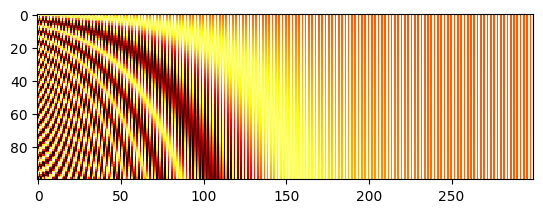

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
# create model
model = MyVit((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)


torch.Size([7, 50, 8])


#### Create main function
In this section we will be creating the main function to create the dataset, initiate the transformer and train it

In [ ]:
from torch.nn.modules.loss import CrossEntropyLoss
def main():
  # transformations to be applied to the input data befor being loaded
  transform = ToTensor()
  # load training and testing data
  train_set = MNIST(root='./datasets', train=True, download=True, transform=transform)
  test_set = MNIST(root='./datasets', train=False, download=True, transform=transform)

  # split training data into train and validation

  # create dataloaders for the training and test data
  train_loader = DataLoader(train_set, 128, True)
  test_loader = DataLoader(test_set, 128, False)

  # Defining model and training options
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
  model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
  N_EPOCHS = 5
  LR = 0.005

  optimizer = Adam(model.parameters(), lr=LR)
  criterion = CrossEntropyLoss()

  # for each epoch train the model on the entire dataset
  for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        # loop through each batch in the data loader
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            # get the features and the targets from each batch
            x, y = batch
            # move the features and the targets to the gpu device
            x, y = x.to(device), y.to(device)
            # get the model predictions given the inputs
            y_hat = model(x)
            # calculate the loss based on the objective function
            loss = criterion(y_hat, y)

            # add the loss value the the total training loss
            train_loss += loss.detach().cpu().item() / len(train_loader)

            # set the optimizer deriviatives to zero
            optimizer.zero_grad()
            # calculate the gradients for the parameters
            loss.backward()
            # perform mathematical optimization using Adam optimizer
            optimizer.step()
        # at the end of each epoch print the total training loss
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

  # Test loop
  with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = criterion(y_hat, y)
      test_loss += loss.detach().cpu().item() / len(test_loader)

      correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
      total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")



